# Burgers' Equation
## A 1D Numerical Experiment of FNOs

This notebooks walks through the Fourier Neural Operator for a 1D problem such as the (time-independent) Burgers equation discussed in Section 5.1 in the paper [Fourier Neural Operator for Parametric Partial Differential Equations](https://arxiv.org/pdf/2010.08895.pdf). The solution operator maps the field equation $A(x)$ at time $t=0$ to $U(x)$ at time $t=1$.

In [1]:
from typing import NamedTuple

import matplotlib.pyplot as plt
import numpy as np
from timeit import default_timer
import yaml

from torch.nn.functional import mse_loss
import torch

from neuralop import count_params
from neuralop.datasets import load_burgers
from neuralop.layers import SpectralConv1d
from neuralop.models import FNO1d
from neuralop.training import LpLoss

np.random.seed(0)
_ = torch.manual_seed(0)  # suppress output

## Configuration

The following configurations control the training and evaluation of the FNO model:

In [2]:
class Config(NamedTuple):
    data_path: str
    """Fully qualified file path to training/testing data"""
    n_train: int
    n_test: int
    train_batch_size: int
    test_batch_size: int
    learning_rate: float
    epochs: int
    iterations: int
    modes: int
    width: int
    subsampling_rate: int
    s: int
    h: int
        
    @staticmethod
    def from_yaml(config_path: str):
        with open(config_path, 'r') as f:
            cfg = yaml.load(f)

        config = Config(
            data_path=cfg['data_path'],
            n_train=cfg['n_train'],
            n_test=cfg['n_test'],
            train_batch_size=cfg['train_batch_size'],
            test_batch_size=cfg['test_batch_size'],
            learning_rate=cfg['learning_rate'],
            epochs=cfg['epochs'],
            iterations=cfg['iterations'],
            modes=cfg['modes'],
            width=cfg['width'],
            subsampling_rate=cfg['subsampling_rate'],
            s=cfg['s'],
            h=cfg['h'],
        )        
        return config


config = Config.from_yaml('fourier_1d.yaml')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'device={device}')

device=cuda


In [3]:
################################################################
# read data
################################################################

# Data is of the shape (number of samples, grid size)
# FIXME colab link: https://drive.google.com/drive/folders/1UnbQh2WWc6knEHbLn-ZaXrKUZhp7pjt-?usp=sharing
# FIXME add zenodo link or streaming (latter for colab)
train_loader, test_loader = load_burgers(
    config.data_path,
    config.n_train,
    config.n_test,
    batch_test=1
)

# Get the shape of outputs (for later testing) from the first testing data point
y_test_shape = test_loader.dataset[0][1]

In [4]:
CUDA_LAUNCH_BLOCKING=1
model = FNO1d(
    # modes_height : number of Fourier modes to keep along the height
    int(config.modes),

    # hidden_channels : width of the FNO (i.e. number of channels)
    int(config.width),
    
    in_channels=2,
    use_mlp=True,
    SpectralConv=SpectralConv1d,
    decompostion_kwargs={'dtype', torch.cdouble},
    fno_block_precision='double',
    dtype=torch.float64,
# )
).cuda() # FIXME

In [5]:
print(F"Model parameter count: {count_params(model):,d}")

Model parameter count: 179,505


In [7]:
################################################################
# training and evaluation
################################################################
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=config.learning_rate,
    weight_decay=1e-4
)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer, T_max=config.iterations)

loss = LpLoss()
for ep in range(int(config.epochs)):
    model.train()
    t1 = default_timer()
    # Mean Squared Error;
    # will be measured pointwise on predicted field function u(x, t)
    # for each discretized point (i.e. by x-value).
    train_mse = 0  
    train_l2 = 0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()
        out = model(x)

        mse = mse_loss(
            out.view(config.train_batch_size, -1),
            y.view(config.train_batch_size, -1), 
            reduction='mean'
        )
        l2 = loss(
            out.view(config.train_batch_size, -1),
            y.view(config.train_batch_size, -1)
        )
        l2.backward() # use the l2 relative loss

        optimizer.step()
        scheduler.step()
        train_mse += mse.item()
        train_l2 += l2.item()

    model.eval()
    test_l2 = 0.0
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)

            out = model(x)
            test_l2 += loss(
                out.view(config.test_batch_size, -1),
                y.view(config.test_batch_size, -1)
            ).item()

    train_mse /= len(train_loader)
    train_l2 /= config.n_train
    test_l2 /= config.n_test

    t2 = default_timer()
    print(
        f'Epoch # {ep}',
        f'Duration:     {t2-t1:9.5f}',
        f'Training MSE: {train_mse:9.5f}',
        f'Training L2:  {train_l2:9.5f}',
        f'Testing L2:   {test_l2:9.5f}',
        '=' * 32,
        sep='\n',
    )

Epoch # 0
Duration:       2.69706
Training MSE:   0.08274
Training L2:    0.52658
Testing L2:     9.66361
Epoch # 1
Duration:       2.55494
Training MSE:   0.00692
Training L2:    0.13580
Testing L2:     3.78131
Epoch # 2
Duration:       2.55520
Training MSE:   0.00099
Training L2:    0.05877
Testing L2:     2.61755
Epoch # 3
Duration:       2.55642
Training MSE:   0.00046
Training L2:    0.04435
Testing L2:     2.30308
Epoch # 4
Duration:       2.56080
Training MSE:   0.00028
Training L2:    0.03545
Testing L2:     1.94399
Epoch # 5
Duration:       2.55584
Training MSE:   0.00020
Training L2:    0.03077
Testing L2:     1.69668
Epoch # 6
Duration:       2.54658
Training MSE:   0.00017
Training L2:    0.02829
Testing L2:     1.63161
Epoch # 7
Duration:       2.55996
Training MSE:   0.00014
Training L2:    0.02668
Testing L2:     1.52931
Epoch # 8
Duration:       2.55677
Training MSE:   0.00018
Training L2:    0.02964
Testing L2:     1.42251
Epoch # 9
Duration:       2.55911
Training MSE

Epoch # 59
Duration:       2.60819
Training MSE:   0.00005
Training L2:    0.01414
Testing L2:     0.77053
Epoch # 60
Duration:       2.60083
Training MSE:   0.00003
Training L2:    0.01192
Testing L2:     1.10206
Epoch # 61
Duration:       2.59795
Training MSE:   0.00004
Training L2:    0.01322
Testing L2:     0.64281
Epoch # 62
Duration:       2.61769
Training MSE:   0.00007
Training L2:    0.01711
Testing L2:     0.46776
Epoch # 63
Duration:       2.59433
Training MSE:   0.00003
Training L2:    0.01039
Testing L2:     0.39130
Epoch # 64
Duration:       2.60067
Training MSE:   0.00002
Training L2:    0.00822
Testing L2:     0.35955
Epoch # 65
Duration:       2.59850
Training MSE:   0.00003
Training L2:    0.01161
Testing L2:     1.31073
Epoch # 66
Duration:       2.61310
Training MSE:   0.00008
Training L2:    0.01850
Testing L2:     0.31729
Epoch # 67
Duration:       2.63673
Training MSE:   0.00002
Training L2:    0.00850
Testing L2:     0.70362
Epoch # 68
Duration:       2.62293
Tr

Epoch # 118
Duration:       2.62163
Training MSE:   0.00002
Training L2:    0.00930
Testing L2:     0.52631
Epoch # 119
Duration:       2.61021
Training MSE:   0.00003
Training L2:    0.01066
Testing L2:     0.40317
Epoch # 120
Duration:       2.61615
Training MSE:   0.00003
Training L2:    0.01090
Testing L2:     0.43614
Epoch # 121
Duration:       2.61744
Training MSE:   0.00003
Training L2:    0.01046
Testing L2:     0.47356
Epoch # 122
Duration:       2.62190
Training MSE:   0.00002
Training L2:    0.00936
Testing L2:     0.20383
Epoch # 123
Duration:       2.63986
Training MSE:   0.00001
Training L2:    0.00667
Testing L2:     0.54067
Epoch # 124
Duration:       2.61476
Training MSE:   0.00003
Training L2:    0.01009
Testing L2:     0.48777
Epoch # 125
Duration:       2.61614
Training MSE:   0.00003
Training L2:    0.01089
Testing L2:     0.41369
Epoch # 126
Duration:       2.62839
Training MSE:   0.00003
Training L2:    0.01058
Testing L2:     0.38431
Epoch # 127
Duration:       

Epoch # 177
Duration:       2.59982
Training MSE:   0.00001
Training L2:    0.00770
Testing L2:     0.41263
Epoch # 178
Duration:       2.60310
Training MSE:   0.00001
Training L2:    0.00748
Testing L2:     0.57952
Epoch # 179
Duration:       2.60409
Training MSE:   0.00001
Training L2:    0.00538
Testing L2:     0.31607
Epoch # 180
Duration:       2.60727
Training MSE:   0.00001
Training L2:    0.00644
Testing L2:     0.30242
Epoch # 181
Duration:       2.60457
Training MSE:   0.00001
Training L2:    0.00767
Testing L2:     0.34688
Epoch # 182
Duration:       2.59271
Training MSE:   0.00001
Training L2:    0.00669
Testing L2:     0.36408
Epoch # 183
Duration:       2.60312
Training MSE:   0.00001
Training L2:    0.00753
Testing L2:     0.32746
Epoch # 184
Duration:       2.60743
Training MSE:   0.00001
Training L2:    0.00701
Testing L2:     0.42648
Epoch # 185
Duration:       2.59965
Training MSE:   0.00002
Training L2:    0.00819
Testing L2:     0.40371
Epoch # 186
Duration:       

Epoch # 236
Duration:       2.69215
Training MSE:   0.00001
Training L2:    0.00504
Testing L2:     0.21472
Epoch # 237
Duration:       2.62881
Training MSE:   0.00000
Training L2:    0.00322
Testing L2:     0.17178
Epoch # 238
Duration:       2.63375
Training MSE:   0.00000
Training L2:    0.00333
Testing L2:     0.19476
Epoch # 239
Duration:       2.62467
Training MSE:   0.00000
Training L2:    0.00367
Testing L2:     0.12725
Epoch # 240
Duration:       2.63919
Training MSE:   0.00000
Training L2:    0.00416
Testing L2:     0.23205
Epoch # 241
Duration:       2.64574
Training MSE:   0.00000
Training L2:    0.00332
Testing L2:     0.14028
Epoch # 242
Duration:       2.62699
Training MSE:   0.00000
Training L2:    0.00374
Testing L2:     0.21606
Epoch # 243
Duration:       2.63395
Training MSE:   0.00001
Training L2:    0.00513
Testing L2:     0.28851
Epoch # 244
Duration:       2.62503
Training MSE:   0.00001
Training L2:    0.00542
Testing L2:     0.23747
Epoch # 245
Duration:       

Epoch # 295
Duration:       2.63002
Training MSE:   0.00000
Training L2:    0.00300
Testing L2:     0.21853
Epoch # 296
Duration:       2.64455
Training MSE:   0.00000
Training L2:    0.00375
Testing L2:     0.20900
Epoch # 297
Duration:       2.63614
Training MSE:   0.00000
Training L2:    0.00363
Testing L2:     0.17498
Epoch # 298
Duration:       2.62977
Training MSE:   0.00000
Training L2:    0.00347
Testing L2:     0.17125
Epoch # 299
Duration:       2.62746
Training MSE:   0.00000
Training L2:    0.00314
Testing L2:     0.09247
Epoch # 300
Duration:       2.62758
Training MSE:   0.00000
Training L2:    0.00312
Testing L2:     0.16776
Epoch # 301
Duration:       2.62508
Training MSE:   0.00000
Training L2:    0.00346
Testing L2:     0.16226
Epoch # 302
Duration:       2.62209
Training MSE:   0.00000
Training L2:    0.00327
Testing L2:     0.11717
Epoch # 303
Duration:       2.62628
Training MSE:   0.00000
Training L2:    0.00340
Testing L2:     0.15811
Epoch # 304
Duration:       

Epoch # 354
Duration:       2.62421
Training MSE:   0.00000
Training L2:    0.00119
Testing L2:     0.06910
Epoch # 355
Duration:       2.63907
Training MSE:   0.00000
Training L2:    0.00122
Testing L2:     0.06645
Epoch # 356
Duration:       2.63602
Training MSE:   0.00000
Training L2:    0.00123
Testing L2:     0.06689
Epoch # 357
Duration:       2.62004
Training MSE:   0.00000
Training L2:    0.00142
Testing L2:     0.10411
Epoch # 358
Duration:       2.62177
Training MSE:   0.00000
Training L2:    0.00139
Testing L2:     0.06520
Epoch # 359
Duration:       2.62534
Training MSE:   0.00000
Training L2:    0.00121
Testing L2:     0.07425
Epoch # 360
Duration:       2.61983
Training MSE:   0.00000
Training L2:    0.00133
Testing L2:     0.09272
Epoch # 361
Duration:       2.63169
Training MSE:   0.00000
Training L2:    0.00140
Testing L2:     0.08655
Epoch # 362
Duration:       2.62014
Training MSE:   0.00000
Training L2:    0.00129
Testing L2:     0.07537
Epoch # 363
Duration:       

Epoch # 413
Duration:       2.61902
Training MSE:   0.00000
Training L2:    0.00101
Testing L2:     0.06032
Epoch # 414
Duration:       2.63600
Training MSE:   0.00000
Training L2:    0.00103
Testing L2:     0.05761
Epoch # 415
Duration:       2.62081
Training MSE:   0.00000
Training L2:    0.00101
Testing L2:     0.05744
Epoch # 416
Duration:       2.63052
Training MSE:   0.00000
Training L2:    0.00098
Testing L2:     0.05701
Epoch # 417
Duration:       2.62482
Training MSE:   0.00000
Training L2:    0.00098
Testing L2:     0.05632
Epoch # 418
Duration:       2.62916
Training MSE:   0.00000
Training L2:    0.00095
Testing L2:     0.05591
Epoch # 419
Duration:       2.63379
Training MSE:   0.00000
Training L2:    0.00095
Testing L2:     0.05543
Epoch # 420
Duration:       2.63185
Training MSE:   0.00000
Training L2:    0.00093
Testing L2:     0.05519
Epoch # 421
Duration:       2.61546
Training MSE:   0.00000
Training L2:    0.00093
Testing L2:     0.05498
Epoch # 422
Duration:       

Epoch # 472
Duration:       2.63628
Training MSE:   0.00000
Training L2:    0.00084
Testing L2:     0.05207
Epoch # 473
Duration:       2.63483
Training MSE:   0.00000
Training L2:    0.00084
Testing L2:     0.05207
Epoch # 474
Duration:       2.62739
Training MSE:   0.00000
Training L2:    0.00084
Testing L2:     0.05209
Epoch # 475
Duration:       2.66342
Training MSE:   0.00000
Training L2:    0.00085
Testing L2:     0.05211
Epoch # 476
Duration:       2.63246
Training MSE:   0.00000
Training L2:    0.00085
Testing L2:     0.05212
Epoch # 477
Duration:       2.61555
Training MSE:   0.00000
Training L2:    0.00085
Testing L2:     0.05212
Epoch # 478
Duration:       2.64331
Training MSE:   0.00000
Training L2:    0.00085
Testing L2:     0.05216
Epoch # 479
Duration:       2.63720
Training MSE:   0.00000
Training L2:    0.00085
Testing L2:     0.05222
Epoch # 480
Duration:       2.61394
Training MSE:   0.00000
Training L2:    0.00085
Testing L2:     0.05225
Epoch # 481
Duration:       

In [ ]:
pred = torch.zeros(len(test_loader), *(y_test_shape[1:]))
index = 0

with torch.no_grad():
    for i, (x, y) in enumerate(test_loader):
        test_l2 = 0
        x, y = x.to(device), y.to(device)

        out = model(x)
        pred[index] = out.view(-1)

        test_l2 += loss(out.view(1, -1), y.view(1, -1)).item()
        # print(index, test_l2)
        index = index + 1

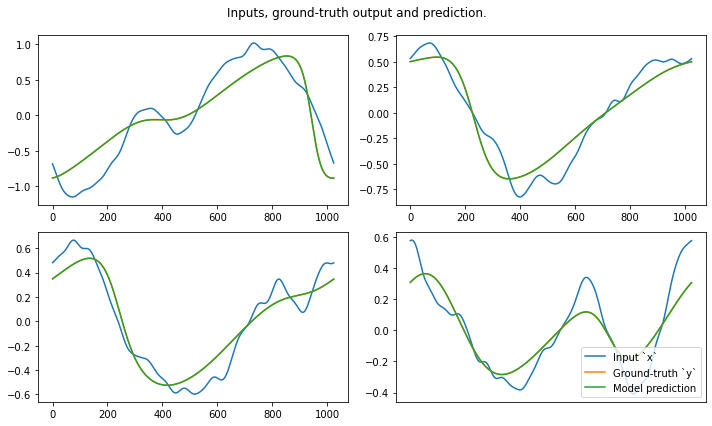

In [15]:
import matplotlib.pyplot as plt
test_samples = test_loader.dataset

fig, axs = plt.subplots(2, 2, figsize=(10, 6)) # , layout='constrained')
for index, ax in enumerate(axs.flat):
    data = test_samples[index * 10]
    # Input ``a`` & Ground-truth ``u``
    a, u = data[0].to(device), data[1].to(device)
    # Model prediction
    out = model(a.unsqueeze(0))
    ax.plot(
        a[0].cpu(),
        label="Input `x`")
    ax.plot(
        u.squeeze().cpu(),
        label="Ground-truth `y`")
    ax.plot(
        out.squeeze().detach().cpu().numpy(),
        label="Model prediction")
    plt.xticks([], [])

fig.suptitle('Inputs, ground-truth output and prediction.', y=0.98)
plt.tight_layout()
plt.legend(loc='lower right')

We can barely see the Ground Truth curve above, so the model's prediction already aggrees with the solver to within a small error.